**Please visit https://ProStepSky.github.io/.**

This work © 2024 by "ProStepSky.github.io จัดทำโดย S.U." is licensed under [CC BY-NC-ND 4.0](http://creativecommons.org/licenses/by-nc-nd/4.0/)  
(อ้างอิงแหล่งที่มา ห้ามนำไปใช้เพื่อการค้า และห้ามดัดแปลง)

---

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Suppress all warnings 
import warnings
warnings.filterwarnings("ignore")

# Import Data

Import การกู้ยืมที่มีสถานะเป็นหนี้สูญ (written-off) ซึ่งได้จากการคัดเลือกเมื่อ notebook ชื่อ 07 - LGD and EAD - Preparing the Data:

In [3]:
loan_data_defaults = pd.read_csv('./data/loan_data_defaults.csv')

# Explore Dependent Variables

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Set the default style of the graphs to the seaborn style. 

วาดกราฟ histogram ของตัวแปรตาม Credit Conversion Factor (CCF: ค่าแปลงสภาพ) โดยใช้ 100 bins:

(array([   3.,   17.,   16.,   44.,   16.,   13.,   71.,   26.,    7.,
          63.,   67.,   17.,   60.,   90.,   23.,   55.,   82.,   42.,
          47.,  123.,   82.,   70.,  122.,   86.,   89.,  110.,  117.,
         111.,  122.,  120.,  135.,  141.,  154.,  146.,  160.,  175.,
         152.,  187.,  202.,  174.,  204.,  208.,  210.,  211.,  241.,
         264.,  281.,  224.,  308.,  267.,  287.,  296.,  340.,  274.,
         365.,  370.,  392.,  364.,  393.,  419.,  411.,  429.,  445.,
         497.,  481.,  478.,  569.,  568.,  599.,  618.,  727.,  691.,
         626.,  805.,  804.,  776.,  881.,  851.,  916.,  934.,  925.,
        1078.,  933., 1218., 1041., 1082., 1336., 1040., 1374., 1073.,
        1406., 1287.,  952., 1414.,  795., 1320.,  578.,  949.,  343.,
         531.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

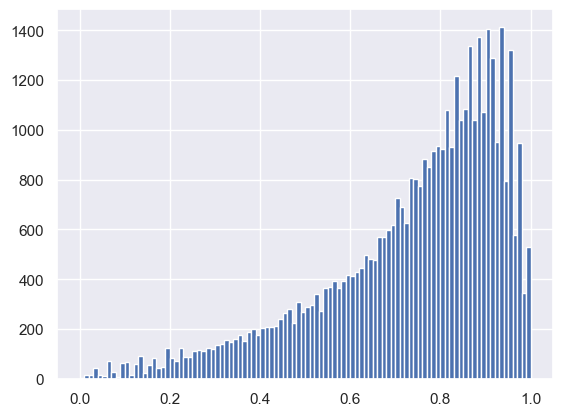

In [5]:
plt.hist(loan_data_defaults['CCF'], bins = 100)

ตัวแปร Credit Conversion Factor (CCF) มีการแจกแจงที่เป็น homogenous มากกว่าตัวแปร recovery rate ที่ใช้ใน LGD model ใน notebook ก่อนหน้า ดังนั้นการใช้ linear regression โดยตรงกับตัวแปร Credit Conversion Factor เลยจะได้ผลลัพธ์ที่ดี

ดังนั้น สำหรับตัวแปร Credit Conversion Factor จะใช้ multiple linear regression ในการสร้าง model

---
---
---

# ➡ <font color='dodgerblue'><u>EAD Model</u></font> ⬅

### Estimation and Interpretation

ทำ train/test split ด้วยอัตราส่วน 80:20

In [6]:
from sklearn.model_selection import train_test_split

ใช้ input เป็น การกู้ยืมที่มีสถานะเป็นหนี้สูญ (written-off) แต่ drop ตัวแปรตาม good_bad, recovery_rate, CCF

ใช้ target เป็น CCF (Credit Conversion Factor: ค่าแปลงสภาพ)

ดังนี้:

In [7]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)

### Preparing the Inputs

In [8]:
#ead_inputs_train.columns.values

สร้างตัวแปร features_all เพื่อเก็บเฉพาะชื่อของตัวแปรอิสระที่ต้องใช้เท่านั้น:

In [9]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

สร้างตัวแปร features_reference_cat เพื่อเก็บชื่อของ dummy variable reference categories (สำหรับ EAD model จะเลือก category ไหนเป็น reference ก็ได้, เพื่อความสะดวกจึงเลือกตามที่เคยเลือกเหมือนตอนที่สร้าง LGD model):

In [10]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

เลือกเก็บเฉพาะตัวแปรที่ต้องใช้เท่านั้น นั่นคือตัวแปรที่มีชื่ออยู่ใน features_all list:

In [11]:
ead_inputs_train = ead_inputs_train[features_all]

ต้องทำการกำจัด 1 dummy variable สำหรับตัวแปรต้นฉบับแต่ละตัว เพื่อป้องกันปัญหา dummy variable trap ซึ่งทำให้เกิด multicollinearity

ทำการ drop ตัวแปรที่เป็น dummy variable reference categories:

In [12]:
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)

### Estimating the Model

ดัดแปลง .fit() method จาก Logistic Regression class เพื่อให้คำนวณ p-values ได้:

In [13]:
# P values for sklearn logistic regression.

# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    # Inherit everything from the original LogisticRegression class.
    def __init__(self,*args,**kwargs):#,**kwargs):
        
        # -------------------------------------------------------
        # This function will be provided upon request. Thank you.
        # -------------------------------------------------------

    # Overwrite .fit() with a function that calculate p-values.
    def fit(self,X,y):
        
        # -------------------------------------------------------
        # This function will be provided upon request. Thank you.
        # -------------------------------------------------------

ดัดแปลง .fit() method จาก Linear Regression class เพื่อให้คำนวณ p-values ได้:

In [14]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        
        # -------------------------------------------------------
        # This function will be provided upon request. Thank you.
        # -------------------------------------------------------

    
    def fit(self, X, y, n_jobs=1):
        
        # -------------------------------------------------------
        # This function will be provided upon request. Thank you.
        # -------------------------------------------------------
        
        return self

สร้าง instance โดยใช้ class ที่ผ่านการดัดแปลงให้สามารถคำนวณ p-values ได้:

In [15]:
reg_ead = LinearRegression()

ทำการ fit model:

In [16]:
reg_ead.fit(ead_inputs_train, ead_targets_train)

LinearRegression()

บันทึก EAD model ลง disk:

In [17]:
import pickle

In [18]:
filehandler = open('./data/ead_model.pkl','wb')
pickle.dump(reg_ead,filehandler)
filehandler.close()

---

เปิด LGD models stage 2 จาก disk:

In [19]:
filehandler = open('./data/lgd_model_stage_2.pkl','rb')
reg_lgd_st_2 = pickle.load(filehandler)
filehandler.close()

---

แสดงจุดตัดแกน, สัมประสิทธิ์ของ, และ p-values:

In [20]:
feature_name = ead_inputs_train.columns.values

In [21]:
# Column titled 'Feature name' with row values contained in the 'feature_name'.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)

# Column titled 'Coefficients'
# with row values the transposed coefficients from the 'LogisticRegression' object
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)

# +1 to the index of every row.
summary_table.index = summary_table.index + 1

# Assign values of the row with index 0.
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]

# Sort the DataFrame by index.
summary_table = summary_table.sort_index()

# Take the result of the newly added method 'p_values'.
p_values = reg_lgd_st_2.p

# Add the 'NaN' value at the beginning of the list,
# which is the same position as the intercept row.
p_values = np.append(np.nan,np.array(p_values))

# Add a new column to the table.
summary_table['p_values'] = p_values

In [22]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.107038e+00,NaN
1,grade:A,-3.009354e-01,0.000000e+00
2,grade:B,-2.348447e-01,0.000000e+00
3,grade:C,-1.709003e-01,0.000000e+00
4,grade:D,-1.190589e-01,2.098099e-12
5,grade:E,-6.723635e-02,1.933778e-03
6,grade:F,-2.022054e-02,2.773634e-01
7,home_ownership:MORTGAGE,-6.335755e-03,6.034960e-02
8,home_ownership:NONE,-5.027459e-03,8.841244e-05
9,home_ownership:OTHER,-2.546560e-03,6.463444e-01


ค่า CCF (Credit Conversion Factor) คืออัตราส่วนของเงินต้นที่ยังค้างชำระต่อจำนวนเงินที่ปล่อยกู้ ณ ขณะที่ผู้ขอกู้ผิดนัดชำระหนี้ถ้าหากว่าผู้ขอกู้ผิดนัดชำระหนี้; นั่นคือ หากค่า CCF ยิ่งสูง ยอดหนี้ ณ ขณะที่ผู้ขอกู้ผิดนัดชำระหนี้ยิ่งสูง; นั่นคือ ยิ่งเสี่ยง

จากตารางข้างบน สามารถแปลผลได้ดังนี้

>ยกตัวอย่าง: หากผู้ขอกู้มี external credit rating ที่เกรด A แล้ว ค่า CCF จะต่ำกว่าที่เกรด G อยู่ 3.009354e-01 หรือ 30% (เนื่องจากเกรด G เป็น reference category)
>
>ยกตัวอย่าง: หากผู้ขอกู้มี external credit rating ที่เกรด B แล้ว ค่า CCF จะสูงกว่าที่เกรด A อยู่ 3.009354e-01 - 2.348447e-01 = 0.0660907 หรือ 6.6%
>
>ยกตัวอย่าง: หากผู้ขอกู้มี purpose เป็น educational แล้ว ค่า CCF จะสูงกว่า purpose ที่เป็น credit_card อยู่ 9.598973e-02 หรือ 9.6% (เนื่องจาก credit_card เป็น reference category)

นอกจากนี้ยังพบว่าค่าสัมประสิทธิ์ของ purpose ที่เป็น educational สูงกว่า purpose อื่น ๆ พอสมควร แสดงว่าผู้ขอกู้ที่กู้ยืมเพื่อการศึกษามีแนวโน้มจะมีความเสี่ยงกว่า purpose อื่น ๆ

สำหรับตัวแปร continuous สามารถแปลผลได้ดังนี้

>ยกตัวอย่าง: หาก int_rate เพิ่มขึ้นหนึ่งหน่วย (1%) ค่า CCF จะต่ำลง 1.161830e-02 หรือ 1.16%
>
>ยกตัวอย่าง: หาก inq_last_6mths (จำนวนครั้งที่มีการตรวจสอบข้อมูลเครดิตภายใน 6 เดือนที่ผ่านมา ยกเว้นเพื่อการกู้รถและเพื่อการกู้บ้าน) มีจำนวนเพิ่มขึ้นหนึ่งหน่วย (1 ครั้ง) ค่า CCF จะเพิ่มขึ้น 1.130830e-02 หรือ 1.13%

---

### Model Validation

เลือกเก็บเฉพาะตัวแปรที่ต้องการใช้เท่านั้น:

In [23]:
ead_inputs_test = ead_inputs_test[features_all]

ทำการ drop ตัวแปรที่เป็น dummy variable reference categories:

In [24]:
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)

In [25]:
ead_inputs_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

ทำการทำนายค่า Credit Conversion Factor (CCF: ค่าแปลงสภาพ):

In [26]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

Reset index ของ DataFrame ของค่าจริง เพื่อให้ index ตรงกับ DataFrame ของค่าทำนาย:

In [27]:
ead_targets_test_temp = ead_targets_test

In [28]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)

ทำการประเมินประสิทธิภาพ model โดยหาค่าสหสัมพันธ์ (correlation) ระหว่างค่าจริง (ead_targets_test_temp) กับ ค่าทำนาย (y_hat_test_ead):

In [29]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.531285
0,0.531285,1.000000


ค่าสหสัมพันธ์ (correlation) ระหว่างค่าจริงกับค่าทำนาย คือ 0.531285 ถือว่าสูงพอสมควร ซึ่งดีต่อ EAD model

ทำการประเมินประสิทธิภาพ model โดยวาดกราฟแสดงการกระจายตัวของผลต่างระหว่างค่าจริง (ead_targets_test) กับ ค่าทำนาย (y_hat_test_ead):

<Axes: xlabel='CCF', ylabel='Density'>

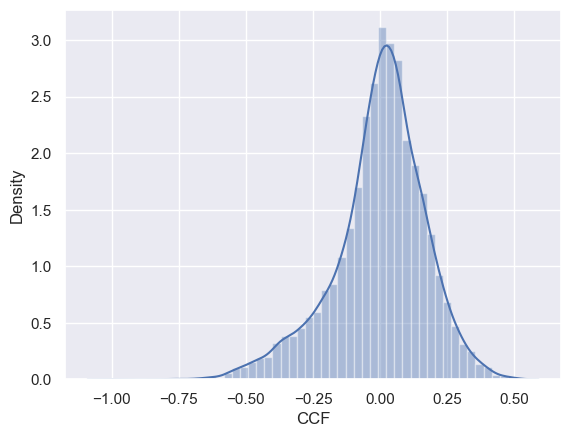

In [30]:
# Plot the distribution of the residuals.
sns.distplot(ead_targets_test - y_hat_test_ead)

จากกราฟข้างบนพบว่า การกระจายตัวของผลต่างระหว่างค่าจริงกับค่าทำนาย มีลักษณะเป็น normal distribution และผลต่างส่วนใหญ่มีการกระจายตัวค่อนข้างสมมาตร ณ บริเวณค่าเท่ากับ 0 และผลต่างส่วนใหญ่กระจุกอยู่ที่บริเวณค่าเท่ากับ 0 บ่งบอกว่า model นี้มีระเบียบวิธีที่ดี และมีความสามารถในการทำนายค่อนข้างดี

แสดงสถิติของผลทำนายค่า Credit Conversion Factor (CCF: ค่าแปลงสภาพ):

In [31]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736006
std,0.105324
min,0.384013
25%,0.661312
50%,0.731782
75%,0.810602
max,1.151939


จากสถิติข้างบน ค่าสูงสุดเกิน 1 เนื่องจาก linear regression model ไม่ได้ถูกจำกัดไว้ว่าต้องให้ output อยู่ระหว่าง 0 ถึง 1 เท่านั้น แม้ว่าข้อมูลที่นำมา train จะอยู่ระหว่าง 0 ถึง 1 ก็ตาม

ดังนั้น จึงต้องตัดค่าที่อยู่นอกพิสัย 0 ถึง 1 ให้เท่ากับ 0 หรือ 1 (นั่นคือ มากกว่า 1 ให้เปลี่ยนเป็น 1 และ น้อยกว่า 0 ให้เปลี่ยนเป็น 0):

In [32]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

แสดงสถิติของผลทำนายค่า Credit Conversion Factor (CCF: ค่าแปลงสภาพ):

In [33]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.735987
std,0.105261
min,0.384013
25%,0.661312
50%,0.731782
75%,0.810602
max,1.000000


จากสถิติข้างบน ตอนนี้คำตอบสุดท้ายของผลทำนายค่า Credit Conversion Factor (CCF: ค่าแปลงสภาพ) อยู่ระหว่าง 0 ถึง 1 แล้ว

สำหรับการทำนายค่า Exposure at Default (EAD: ยอดหนี้เมื่อลูกหนี้ผิดชำระหนี้) จะใช้ค่า CCF คูณด้วย funded_amnt (จำนวนเงินที่ปล่อยกู้) จะไปต่อที่ notebook ถัดไป